# Model splitting for parallel and serial MODFLOW 6

The model splitting functionality for MODFLOW 6 is shown in this notebook. Model splitting via the `Mf6Splitter()` class can be performed on groundwater flow models as well as combined groundwater flow and transport models. The `Mf6Splitter()` class maps a model's connectivity and then builds new models, with exchanges and movers between the new models, based on a user defined array of model numbers.

The `Mf6Splitter()` class supports Structured, Vertex, and Unstructured Grid models.

In [1]:
import flopy
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from flopy.mf6.utils import Mf6Splitter
from flopy.plot import styles

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version

## Example 1: splitting a simple structured grid model

This example shows the basics of using the `Mf6Splitter()` class and applies the method to the Freyberg (1988) model.

In [2]:
simulation_ws = Path("../../examples/mf6-freyberg")

Load the simulation

In [3]:
sim = flopy.mf6.MFSimulation.load(sim_ws=simulation_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package riv...
    loading package wel...
    loading package rch...
  loading solution package freyberg...


Change the working directory, write input files, and run the simulation

In [4]:
# live coding


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package freyberg...
  writing model freyberg...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd-1...
    writing package riv-1...
    writing package wel-1...
    writing package rch-1...
FloPy is using the following executable to run the model: ..\..\..\..\..\AppData\Local\flopy\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 10 2022 05:57:01 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS)

Visualize the head results and boundary conditions from this model.

In [5]:
# live coding


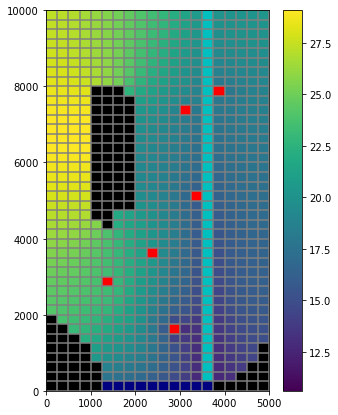

In [6]:
fig, ax = plt.subplots(figsize=(5, 7))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
heads = gwf.output.head().get_alldata()[-1]
heads = np.where(heads == 1e30, np.nan, heads)
vmin = np.nanmin(heads)
vmax = np.nanmax(heads)
pc = pmv.plot_array(heads, vmin=vmin, vmax=vmax)
pmv.plot_bc("WEL")
pmv.plot_bc("RIV", color="c")
pmv.plot_bc("CHD")
pmv.plot_grid()
pmv.plot_ibound()
plt.colorbar(pc);

### Creating an array that defines the new models

In order to split models, the model domain must be discretized using unique model numbers. Any number of models can be created, however all of the cells within each model must be contiguous.

The `Mf6Splitter()` class accept arrays that are equal in size to the number of cells per layer (`StructuredGrid` and `VertexGrid`) or the number of model nodes (`UnstructuredGrid`).

In this example, the model is split diagonally into two model domains.

In [7]:
modelgrid = gwf.modelgrid

In [8]:
array = np.ones((modelgrid.nrow, modelgrid.ncol), dtype=int)
ncol = 1
for row in range(modelgrid.nrow):
    if row != 0 and row % 2 == 0:
        ncol += 1
    array[row, ncol:] = 2

Plot the two domains that the model will be split into

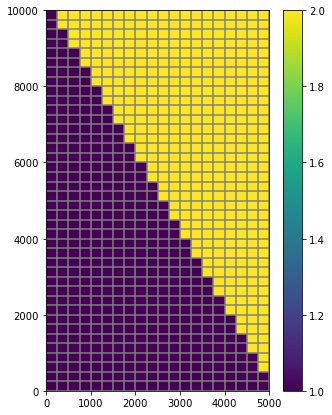

In [9]:
fig, ax = plt.subplots(figsize=(5, 7))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pc = pmv.plot_array(array)
lc = pmv.plot_grid()
plt.colorbar(pc)
plt.show()

### Splitting the model using `Mf6Splitter()`

The `Mf6Splitter()` class accepts one required parameter and one optional parameter. These parameters are:
   - `sim`: A flopy.mf6.MFSimulation object
   - `modelname`: optional, the name of the model being split. If omitted Mf6Splitter grabs the first groundwater flow model listed in the simulation

In [10]:
# live coding


The model splitting is then performed by calling the `split_model()` function. `split_model()` accepts an array that is either the same size as the number of cells per layer (`StructuredGrid` and `VertexGrid`) model or the number of nodes in the model (`UnstructuredGrid`).

This function returns a new `MFSimulation` object that contains the split models and exchanges between them

In [11]:
# live coding


In [12]:
# now to write and run the simulation


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package sim_1_2.gwfgwf...
  writing model freyberg_1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd-1...
    writing package riv-1...
    writing package wel-1...
    writing package rch-1...
  writing model freyberg_2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd-1...
    writing package riv-1...
    writing package wel-1...
    writing package rch-1...
FloPy is using the following executable to run the model: ..\..\..\..\..\..\AppData\Local\flopy\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MOD

### Visualize and reassemble model output

Both models are visualized side by side

In [13]:
# visualizing both models side by side
ml0 = new_sim.get_model("freyberg_1")
ml1 = new_sim.get_model("freyberg_2")

In [14]:
heads0 = ml0.output.head().get_alldata()[-1]
heads1 = ml1.output.head().get_alldata()[-1]

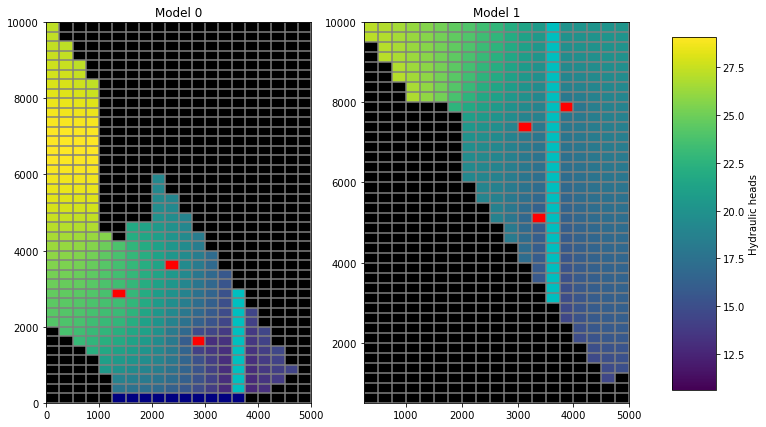

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
pmv = flopy.plot.PlotMapView(ml0, ax=ax0)
pmv.plot_array(heads0, vmin=vmin, vmax=vmax)
pmv.plot_ibound()
pmv.plot_grid()
pmv.plot_bc("WEL")
pmv.plot_bc("RIV", color="c")
pmv.plot_bc("CHD")
ax0.set_title("Model 0")

pmv = flopy.plot.PlotMapView(ml1, ax=ax1)
pc = pmv.plot_array(heads1, vmin=vmin, vmax=vmax)
pmv.plot_ibound()
pmv.plot_bc("WEL")
pmv.plot_bc("RIV", color="c")
pmv.plot_grid()
ax1.set_title("Model 1")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label="Hydraulic heads")

## Hands on example: Synthetic desert

For this example load the synthetic desert model from Day 1, split the model into at least 4 models and inspect the outputs.

In [16]:
sim_ws = Path("../../examples/synthetic_desert/model_files")

In [17]:
sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws)
success, buff = sim.run_simulation(silent=True)
assert success

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package evt...
    loading package rch...
    loading package ghb...
    loading package oc...
  loading solution package synth_desert...


Using information from the groundwater flow model instance or the modelgrid, create an array to split the model into 4 or more models.

In [18]:
gwf = sim.get_model()
modelgrid = gwf.modelgrid

In [19]:
# create an array to split your model


Visualize your array using matplotlib or flopy's `PlotMapView`

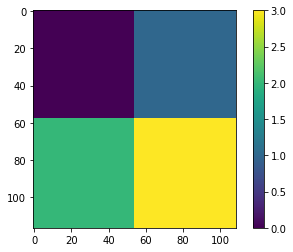

In [20]:
# visualize your array


split the model using `Mf6Splitter()`. Name the new simulation object `new_sim`

In [21]:
# split the model using Mf6Splitter


sim_name = sim
sim_path = C:\Users\jlarsen\Desktop\parallel-modflow\notebooks\day2
exe_name = mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = sim


###################
Package sim.tdis
###################

package_name = sim.tdis
filename = sim.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = sim


###################
Package ims_-1
###################

package_name = ims_-1
filename = sim.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = sim


###################
Package sim_0_1.gwfgwf
###################

package_name = sim_0_1.gwfgwf
filename = sim_0_1.gwfgwf
package_type = gwfgwf
model_or_simulation_package = simulation
simulation_name = sim


###################
Package sim_0_2.gwfgwf
###################

package_name = sim_0_2.gwfgwf
filename = sim_0_2.gwfgwf
package_type = gw

write the simulation to a new directory and run it

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package sim_0_1.gwfgwf...
  writing package sim_0_2.gwfgwf...
  writing package sim_1_3.gwfgwf...
  writing package sim_2_3.gwfgwf...
  writing model synth_desert_0...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package evt_0...
    writing package rch_0...
    writing package ghb_0...
    writing package oc...
  writing model synth_desert_1...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package evt_0...
    writing package rch_0...
    writing package ghb_0...
    writing package oc...
  writing model synth_desert_2...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package evt_0...
    writing package rch_0...
    wri

    Solving:  Stress period:     1    Time step:   103
    Solving:  Stress period:     1    Time step:   104
    Solving:  Stress period:     1    Time step:   105
    Solving:  Stress period:     1    Time step:   106
    Solving:  Stress period:     1    Time step:   107
    Solving:  Stress period:     1    Time step:   108
    Solving:  Stress period:     1    Time step:   109
    Solving:  Stress period:     1    Time step:   110
    Solving:  Stress period:     1    Time step:   111
    Solving:  Stress period:     1    Time step:   112
    Solving:  Stress period:     1    Time step:   113
    Solving:  Stress period:     1    Time step:   114
    Solving:  Stress period:     1    Time step:   115
    Solving:  Stress period:     1    Time step:   116
    Solving:  Stress period:     1    Time step:   117
    Solving:  Stress period:     1    Time step:   118
    Solving:  Stress period:     1    Time step:   119
    Solving:  Stress period:     1    Time step:   120
    Solvin

    Solving:  Stress period:     1    Time step:   253
    Solving:  Stress period:     1    Time step:   254
    Solving:  Stress period:     1    Time step:   255
    Solving:  Stress period:     1    Time step:   256
    Solving:  Stress period:     1    Time step:   257
    Solving:  Stress period:     1    Time step:   258
    Solving:  Stress period:     1    Time step:   259
    Solving:  Stress period:     1    Time step:   260
    Solving:  Stress period:     1    Time step:   261
    Solving:  Stress period:     1    Time step:   262
    Solving:  Stress period:     1    Time step:   263
    Solving:  Stress period:     1    Time step:   264
    Solving:  Stress period:     1    Time step:   265
    Solving:  Stress period:     1    Time step:   266
    Solving:  Stress period:     1    Time step:   267
    Solving:  Stress period:     1    Time step:   268
    Solving:  Stress period:     1    Time step:   269
    Solving:  Stress period:     1    Time step:   270
    Solvin

(True, [])

Visualize the heads in all four models

In [30]:
heads = []
models = []
vmin = 1e+10
vmax = -1e+10
for mname in new_sim.model_names:
    ml = new_sim.get_model(mname)
    head = ml.output.head().get_alldata()[-1]
    head[head == 1e+30] = np.nan
    if np.nanmin(head) < vmin:
        vmin = np.nanmin(head)
    if np.nanmax(head) > vmax:
        vmax = np.nanmax(head)
    heads.append(head)
    models.append(ml)

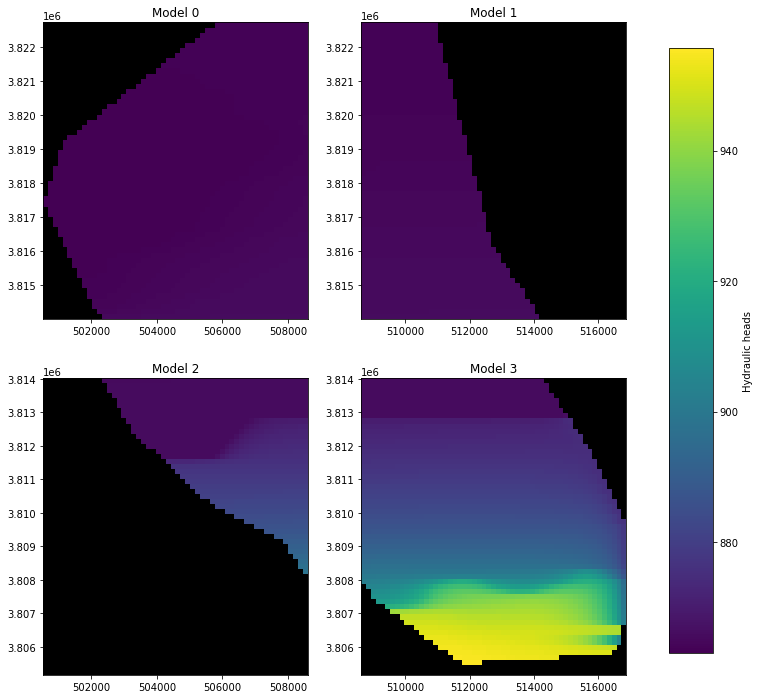

In [31]:
nrow, ncol = 2, 2 # update this for your model if you've split it into more than 4 models
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12))
for ix, ax in enumerate(axs.ravel()):
    ml = models[ix]
    pmv = flopy.plot.PlotMapView(ml, ax=ax)
    pc = pmv.plot_array(heads[ix], vmin=vmin, vmax=vmax)
    pmv.plot_ibound()
    ax.set_title(f"Model {ix}")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label="Hydraulic heads")

### Reassemble the heads to the original model shape for plotting

The `Mf6Splitter()` has a method called `reconstruct_array()` that can be used to assemble arrays from multiple models into the original model shape.

Create a dictionary of {model number : head_array} and use the `reconstruct_array()` method to get a numpy array that is the original shape of the unsplit model.

now plot the reconstructed arrays

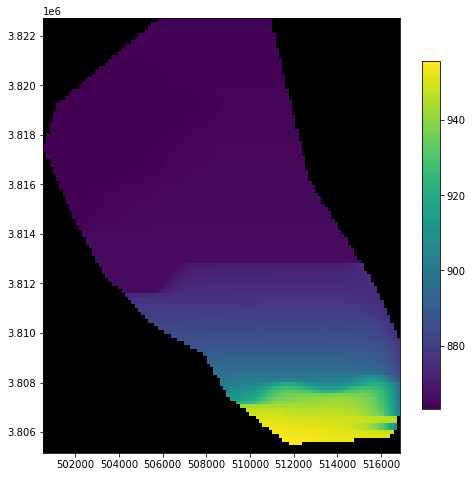

## Create a load balanced splitting mask for a model

In the previous examples, the watershed model splitting mask was defined by the user. `Mf6Splitter` also has a method called `optimize_splitting_mask` that creates a mask based on the number of models the user would like to generate.

The `optimize_splitting_mask()` method generates a vertex weighted adjacency graph, based on the number active and inactive nodes in all layers of the model. This adjacency graph is then provided to `pymetis` which does the work for us and returns a membership array for each node.

The `optimize_splitting_mask()` method just needs the number of models supplied to it.

In [51]:
# live coding


Plot the load balanced array

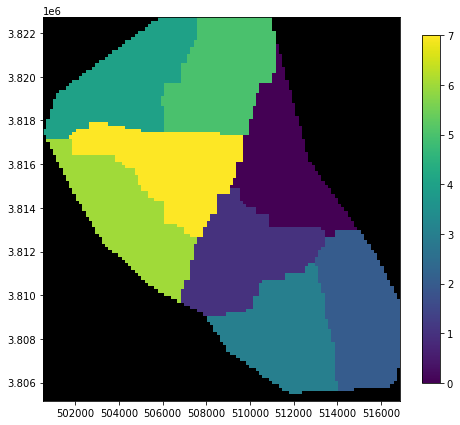

In [52]:
# live coding


split, write, and run the split simulation

In [53]:
new_sim = mfsplit.split_model(array)
new_sim.set_sim_path(sim_ws)
new_sim.write_simulation()
new_sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package sim_0_1.gwfgwf...
  writing package sim_0_2.gwfgwf...
  writing package sim_0_5.gwfgwf...
  writing package sim_0_7.gwfgwf...
  writing package sim_1_2.gwfgwf...
  writing package sim_1_3.gwfgwf...
  writing package sim_1_6.gwfgwf...
  writing package sim_1_7.gwfgwf...
  writing package sim_2_3.gwfgwf...
  writing package sim_4_5.gwfgwf...
  writing package sim_4_6.gwfgwf...
  writing package sim_4_7.gwfgwf...
  writing package sim_5_7.gwfgwf...
  writing package sim_6_7.gwfgwf...
  writing model synth_desert_0...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package evt_0...
    writing package rch_0...
    writing package ghb_0...
    writing package oc...
  writing model synth_desert_1...
    writing model name file...
    writing package dis...
    writing pack

    Solving:  Stress period:     1    Time step:    80
    Solving:  Stress period:     1    Time step:    81
    Solving:  Stress period:     1    Time step:    82
    Solving:  Stress period:     1    Time step:    83
    Solving:  Stress period:     1    Time step:    84
    Solving:  Stress period:     1    Time step:    85
    Solving:  Stress period:     1    Time step:    86
    Solving:  Stress period:     1    Time step:    87
    Solving:  Stress period:     1    Time step:    88
    Solving:  Stress period:     1    Time step:    89
    Solving:  Stress period:     1    Time step:    90
    Solving:  Stress period:     1    Time step:    91
    Solving:  Stress period:     1    Time step:    92
    Solving:  Stress period:     1    Time step:    93
    Solving:  Stress period:     1    Time step:    94
    Solving:  Stress period:     1    Time step:    95
    Solving:  Stress period:     1    Time step:    96
    Solving:  Stress period:     1    Time step:    97
    Solvin

    Solving:  Stress period:     1    Time step:   233
    Solving:  Stress period:     1    Time step:   234
    Solving:  Stress period:     1    Time step:   235
    Solving:  Stress period:     1    Time step:   236
    Solving:  Stress period:     1    Time step:   237
    Solving:  Stress period:     1    Time step:   238
    Solving:  Stress period:     1    Time step:   239
    Solving:  Stress period:     1    Time step:   240
    Solving:  Stress period:     1    Time step:   241
    Solving:  Stress period:     1    Time step:   242
    Solving:  Stress period:     1    Time step:   243
    Solving:  Stress period:     1    Time step:   244
    Solving:  Stress period:     1    Time step:   245
    Solving:  Stress period:     1    Time step:   246
    Solving:  Stress period:     1    Time step:   247
    Solving:  Stress period:     1    Time step:   248
    Solving:  Stress period:     1    Time step:   249
    Solving:  Stress period:     1    Time step:   250
    Solvin

(True, [])

## Saving node mapping to file

`Mf6Splitter` has a method, `save_node_mapping()` to save the internal model splitter's node mapping information to file.

The `save_node_mapping()` method accepts a JSON file name.

In [54]:
# live code 


## Loading a saved node map from file

`Mf6Splitter` has a `load_node_mapping()` function that allows the user to load an existing node mapping for array reconstuction.

The `load_node_mapping()` function needs the split simulation object and the JSON node mapping file

In [62]:
new_sim2 = flopy.mf6.MFSimulation.load(sim_ws=sim_ws)

# live code


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package evt...
    loading package rch...
    loading package ghb...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package evt...
    loading package rch...
    loading package ghb...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package evt...
    loading package rch...
    loading package ghb...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package evt...
    loading package rch...
    loading package ghb...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package npf

sim_name = modflowsim
sim_path = C:\Users\jlarsen\Desktop\parallel-modflow\notebooks\day2\..\..\examples\synthetic_desert\model_files\split_model\split_model
exe_name = mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = modflowsim


###################
Package sim.tdis
###################

package_name = sim.tdis
filename = sim.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = modflowsim


###################
Package synth_desert_0
###################

package_name = synth_desert_0
filename = sim.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = modflowsim


@@@@@@@@@@@@@@@@@@@@
Model synth_desert_0
@@@@@@@@@@@@@@@@@@@@

name = synth_desert_0
model_type = gwf6
version = mf6
model_relative_path = 

###################
Package dis
###################

package_name = dis
filename = synth_d

Plot up the split model's heads

In [64]:
head_dict = {}
for ix, mname in enumerate(new_sim2.model_names):
    ml = new_sim2.get_model(mname)
    head_dict[ix] = ml.output.head().get_alldata()[-1]

ra_heads = mfsplit.reconstruct_array(head_dict)

['synth_desert_0', 'synth_desert_1', 'synth_desert_2', 'synth_desert_3', 'synth_desert_4', 'synth_desert_5', 'synth_desert_6', 'synth_desert_7']


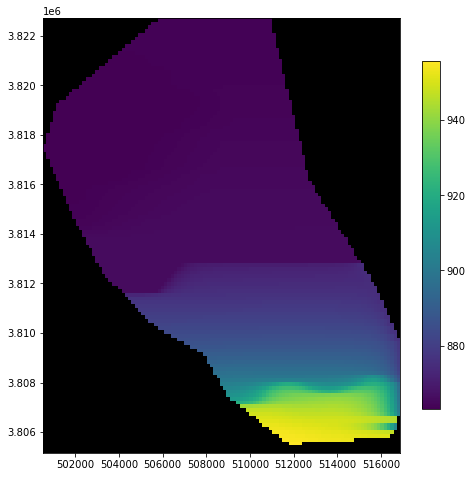

In [65]:
fig, ax = plt.subplots(figsize=(8, 8))

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(ra_heads)
ib = pmv.plot_inactive()
plt.colorbar(pc, shrink=0.8);

More information about the model splitter can be found [here](https://flopy.readthedocs.io/en/latest/Notebooks/raster_intersection_example.html)